In [15]:
import math
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt

from functions import cost
from utils import from_unit_cube, to_unit_cube

%load_ext autoreload
%autoreload 2

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
train_x = torch.rand([10,5])
train_x_denormalized = from_unit_cube(train_x[:, 0], "nnodes")
print(train_x_denormalized)


tensor([28.6270,  3.6019, 20.5715, 21.1878, 28.9258,  9.1499,  2.2910, 17.4273,
         7.2391, 19.9374])


In [4]:
# Preparing the data
def f(x):
    return torch.sin(2*torch.pi*x)

train_x = torch.linspace(0,1,100)
train_y = f(train_x) + torch.randn(train_x.shape) * math.sqrt(0.04)

f = cost
train_x = torch.rand([10,5])
train_y = cost(from_unit_cube(train_x[:,0], "phi"),
               from_unit_cube(train_x[:,0], "chi"),
               from_unit_cube(train_x[:,0], "nnodes"),
               from_unit_cube(train_x[:,0], "ntasks"),
               from_unit_cube(train_x[:,0], "mem"))
print("train_x: ", train_x.shape)
print("train_y: ", train_y.shape)

train_x:  torch.Size([10, 5])
train_y:  torch.Size([10])


In [5]:
# GP Model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
        

# Training the model

# Evaluating the model

In [6]:
# Training the model
training_iter = 50

model.train() # put the gpytorch model in training mode?
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 3892.397   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 3576.566   lengthscale: 0.744   noise: 0.744
Iter 3/50 - Loss: 3311.011   lengthscale: 0.796   noise: 0.798
Iter 4/50 - Loss: 3084.668   lengthscale: 0.844   noise: 0.854
Iter 5/50 - Loss: 2887.994   lengthscale: 0.888   noise: 0.912
Iter 6/50 - Loss: 2713.739   lengthscale: 0.924   noise: 0.972
Iter 7/50 - Loss: 2556.990   lengthscale: 0.952   noise: 1.033
Iter 8/50 - Loss: 2414.627   lengthscale: 0.973   noise: 1.096
Iter 9/50 - Loss: 2284.670   lengthscale: 0.986   noise: 1.161
Iter 10/50 - Loss: 2165.772   lengthscale: 0.993   noise: 1.226
Iter 11/50 - Loss: 2056.922   lengthscale: 0.994   noise: 1.292
Iter 12/50 - Loss: 1957.283   lengthscale: 0.991   noise: 1.359
Iter 13/50 - Loss: 1866.114   lengthscale: 0.984   noise: 1.426
Iter 14/50 - Loss: 1782.740   lengthscale: 0.974   noise: 1.493
Iter 15/50 - Loss: 1706.527   lengthscale: 0.963   noise: 1.560
Iter 16/50 - Loss: 1636.883   lengthscale: 0.949 

In [51]:
# Get all points to draw inference from
# compute all the possibilities of discrete system configurations combinations

nnodes = torch.arange(2,33)
ntasks = torch.arange(2,11)
mem = torch.tensor([4,8,16,32,64])

nnodes_normalized = to_unit_cube(nnodes, variable_type="nnodes")
ntasks_normalized = to_unit_cube(ntasks, variable_type="ntasks")
mem_normalized = to_unit_cube(mem, variable_type="mem")

config_opts = torch.tensor(
                np.array(np.meshgrid(nnodes_normalized, ntasks_normalized, mem_normalized)).T.reshape(-1, 3))

In [56]:
phi = 0.5
chi = 0.5

phi_array = (torch.ones(config_opts.shape[0])*phi).unsqueeze(-1)
chi_array = (torch.ones(config_opts.shape[0])*chi).unsqueeze(-1)

print(phi_array.shape, chi_array.shape, config_opts.shape)

test_x = torch.hstack([phi_array, chi_array, config_opts])

torch.Size([1395, 1]) torch.Size([1395, 1]) torch.Size([1395, 3])


In [58]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()


with torch.no_grad():
    observed_pred = likelihood(model(test_x))

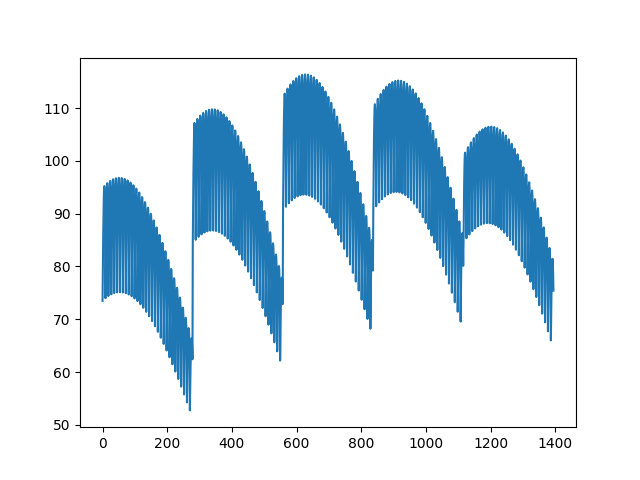

In [62]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(observed_pred.mean.numpy())

In [66]:
lowest_index = np.argmin(observed_pred.mean.numpy())

270

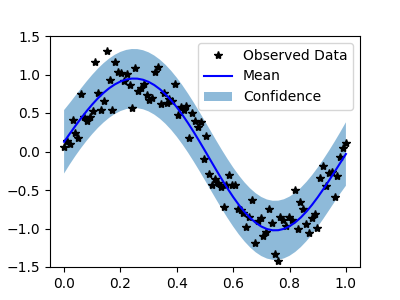

In [6]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-1.5, 1.5])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])